In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [147]:
# Readind the csv dataset
full_data = pd.read_csv('data/diabetic_data.csv')

In [148]:
# Getting the first encounter (by minimun encounter_id per patient)
first_encounter_per_patient = full_data.groupby('patient_nbr').encounter_id.agg('min')
first_encounter = full_data.loc[full_data.encounter_id.isin(first_encounter_per_patient)]
first_encounter.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [149]:
# Thru visual inspection of the data, seems like '?' denotes the missing values on the dataset. Let's check
pd.isnull(first_encounter).describe().loc['unique'] > 1

encounter_id                False
patient_nbr                 False
race                        False
gender                      False
age                         False
weight                      False
admission_type_id           False
discharge_disposition_id    False
admission_source_id         False
time_in_hospital            False
payer_code                  False
medical_specialty           False
num_lab_procedures          False
num_procedures              False
num_medications             False
number_outpatient           False
number_emergency            False
number_inpatient            False
diag_1                      False
diag_2                      False
diag_3                      False
number_diagnoses            False
max_glu_serum               False
A1Cresult                   False
metformin                   False
repaglinide                 False
nateglinide                 False
chlorpropamide              False
glimepiride                 False
acetohexamide 

In [150]:
# Given that none of the columns have NaN values, let's assume that '?' is 'missing data'

In [151]:
# Defines a function that return columns having a given char and the % the char appears on the data
def columns_have_char(df, char):
    columns_with_char = {}
    
    for col in df.columns:
        string_col = df[col].astype(str)
        number_of_observations = sum(string_col == char)
        
        if number_of_observations > 0:
            columns_with_char[col] = "{:.2%}".format(number_of_observations / df[col].count())
        
    return columns_with_char

In [152]:
# Exams the dataset seeking for missing values defined as "?"
list_col = columns_have_char(first_encounter,'?')
list_col

{'race': '2.72%',
 'weight': '96.01%',
 'payer_code': '43.41%',
 'medical_specialty': '48.21%',
 'diag_1': '0.02%',
 'diag_2': '0.41%',
 'diag_3': '1.71%'}

In [153]:
# Two possible actions were considered for each column in "list_col":
# 1) Fill mising values with "unknown" or "other";
# 2) Drop the column.

# After handling, the resulting dataset will be stored on 'final_df'
final_df = first_encounter

In [154]:
# 'race', 'diag_1', 'diag_2' and 'diag_3' columns have a 'Other' category, so action 1 for them
pd.options.mode.chained_assignment = None
for col in ['race', 'diag_1', 'diag_2', 'diag_3']:
    final_df.loc[final_df[col] == '?', col] = 'Other'

In [155]:
final_df.race.value_counts()

Caucasian          53491
AfricanAmerican    12887
Other               3126
Hispanic            1517
Asian                497
Name: race, dtype: int64

In [156]:
# 'weight' have too many missing values, so action 2
final_df = final_df.drop(columns=['weight'])

In [157]:
# 'payer_code' and 'medical_specialty' have less than 50% of missing data.
# I decided to not drop these columns yet. Further analisys will tell if these columns are significant or not
for col in ['payer_code', 'medical_specialty']:
    col_replace = final_df[col].replace({'?':'Unknown'})
    final_df[col] = col_replace

In [158]:
# Defines a functions that check if unique values of all columns are less than some number
def check_unique_values(df,unique_values_number):
    
    result_columns = {}
    
    for col in df.columns:
        unique_values_count = len(df[col].unique())
        
        if unique_values_count <= unique_values_number:
            result_columns[col] = unique_values_count
        
    return result_columns

In [159]:
# Returns a list of columns that have only one class
check_unique_values(final_df,1)

{'examide': 1, 'citoglipton': 1, 'glimepiride-pioglitazone': 1}

In [160]:
# Removing columns with only one category
columns_to_drop = check_unique_values(final_df, 1).keys()
final_df = final_df.drop(columns=columns_to_drop)

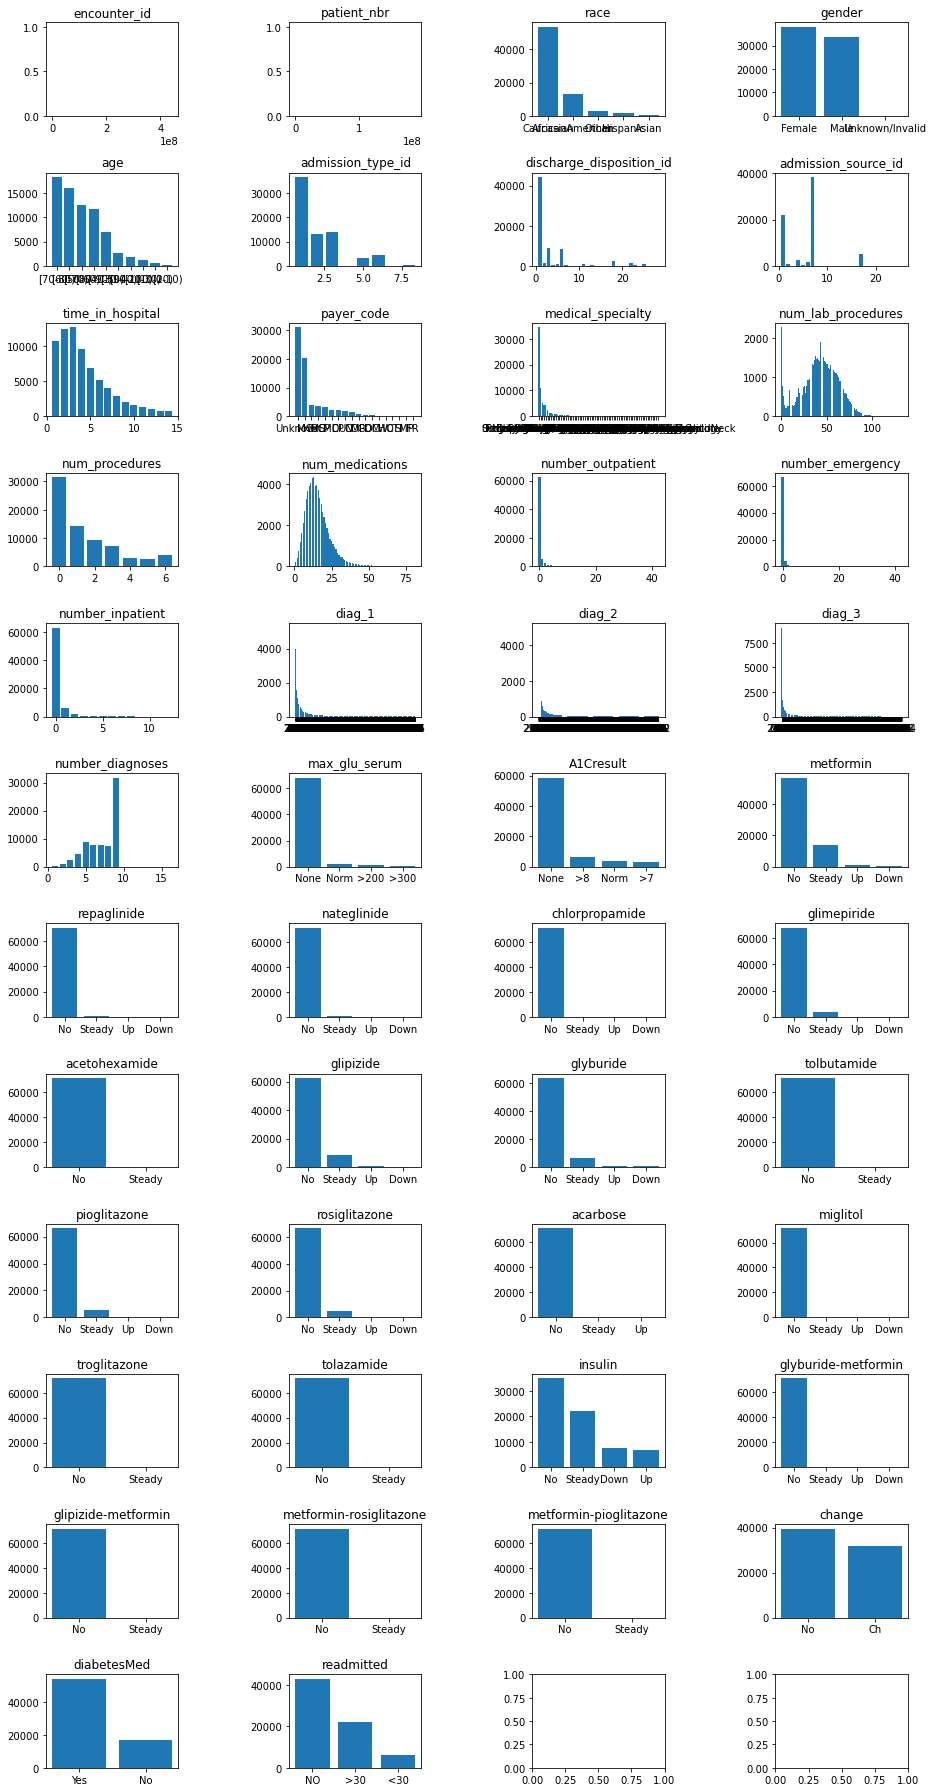

In [161]:
# Plots bar charts for all columns
list_columns = final_df.columns
n_cols = 4
n_rows = math.ceil(len(list_columns)/n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=[13,25])

for i in range(0, n_rows):
    for j in range(0, n_cols):
        key = (n_cols * i) + j
        if key < len(list_columns):
            g = final_df[list_columns[key]].value_counts()
            names = list(g.keys())
            values = list(g.values)

            axs[i, j].bar(names, values)
            axs[i, j].set_title(list_columns[key])

plt.tight_layout()
plt.show()

In [162]:
# Defines a function to check for skewed data given a percentual
def skewed_columns(df, percentual):
    cols_with_skewed_data = []
    
    for col in df.columns:
        value_count = df[col].value_counts() / df[col].count()
        if value_count.max() >= percentual:
            cols_with_skewed_data.append(col)
            
    return cols_with_skewed_data

In [163]:
# List the columns with one class representing 75% of concentration
list_columns = skewed_columns(final_df, 0.75)
list_columns

['number_outpatient',
 'number_emergency',
 'number_inpatient',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'glyburide-metformin',
 'glipizide-metformin',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'diabetesMed']

In [164]:
# The columns listed before was considered candidates to drop. 
# Checking the graphs and the meaning thru the article, some was excluded
columns_to_keep = ['number_outpatient',
                 'number_emergency',
                 'number_inpatient',
                 'max_glu_serum',
                 'A1Cresult',
                 'metformin',
                 'diabetesMed']

In [165]:
# Resulting columns to drop
to_drop = [col for col in list_columns if col not in columns_to_keep]

final_df = final_df.drop(columns=to_drop)

In [166]:
pd.options.display.max_columns = None
final_df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,insulin,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,Other,Other,1,None,None,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,0,18,0,0,0,276,250.01,255,9,None,None,No,Up,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,1,16,0,0,0,8,250.43,403,7,None,None,No,Up,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,0,8,0,0,0,197,157,250,5,None,None,No,Steady,Ch,Yes,NO


In [167]:
# The feature 'patint_nbr' represents a identifier for patint and should be removed from the dataset before running the model
indexed_data = final_df.drop(columns=['patient_nbr']).set_index('encounter_id')
indexed_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,insulin,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,
2278392,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,Other,Other,1,None,None,No,No,No,No,NO
149190,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,0,18,0,0,0,276,250.01,255,9,None,None,No,Up,Ch,Yes,>30
64410,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,Yes,NO
500364,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,1,16,0,0,0,8,250.43,403,7,None,None,No,Up,Ch,Yes,NO
16680,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,0,8,0,0,0,197,157,250,5,None,None,No,Steady,Ch,Yes,NO


In [168]:
# Before using any model, we need to encode the data
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

# This dictionary holds the original classes
definition = defaultdict(LabelEncoder)

encoded_data = indexed_data.apply(lambda col : definition[col.name].fit_transform(col))
encoded_data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,insulin,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,
2278392,2,0,0,5,23,0,0,16,36,40,0,0,0,0,0,123,687,717,0,2,2,1,1,1,0,2
149190,2,0,1,0,0,6,2,16,69,58,0,17,0,0,0,141,77,112,8,2,2,1,3,0,1,1
64410,0,0,2,0,0,6,1,16,69,10,5,12,2,0,1,444,76,736,5,2,2,1,1,1,1,2
500364,2,1,3,0,0,6,1,16,69,43,1,15,0,0,0,542,92,238,6,2,2,1,3,0,1,2
16680,2,1,4,0,0,6,0,16,69,50,0,7,0,0,0,54,23,77,4,2,2,1,2,0,1,2


In [169]:
# Spliting the training and validation data
from sklearn.model_selection import train_test_split

y = encoded_data['readmitted']
X = encoded_data.drop(columns=['readmitted'])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 1) 

In [170]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state = 1)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [171]:
# Making prediction for validation data
y_pred = classifier.predict(X_val)

In [172]:
# Decoding the predicted and validation data
y_pred_uncoded = definition['readmitted'].inverse_transform(y_pred)
y_val_uncoded = definition['readmitted'].inverse_transform(y_val)

In [173]:
# Creates a confusion matrix to compare predicted with validation 
original_result = pd.crosstab(y_val_uncoded, y_pred_uncoded, rownames=['Original'], colnames=['Predicted'], margins=True)
original_result

Predicted,<30,>30,NO,All
Original,,,,
<30,8,331,1199,1538
>30,4,1240,4353,5597
NO,4,941,9800,10745
All,16,2512,15352,17880


In [174]:
# According to the results, the model performs well on predicting when a patient won't be readmitted
# This may be caused by the high concentration of data identified as "NO" on the dataset
# Some further actions will be tested seeking to increase the explainability of the classifier

In [175]:
# Checking features importance
importance = pd.DataFrame([classifier.feature_importances_], index=['Importance']).T.set_index(X.columns)
importance.sort_values(by=['Importance'], ascending=False)

,Importance
num_lab_procedures,0.100675
diag_1,0.093633
diag_2,0.093132
diag_3,0.090390
num_medications,0.085680
time_in_hospital,0.060663
age,0.046875
medical_specialty,0.043688
num_procedures,0.040712
number_diagnoses,0.040249


In [176]:
# Removing features with low importance
low_importance = ['number_emergency', 'diabetesMed', 'max_glu_serum']
second_run = indexed_data.drop(columns=low_importance)
second_run.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,metformin,insulin,change,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,,,
2278392,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,0,1,0,0,250.83,Other,Other,1,None,No,No,No,NO
149190,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,0,18,0,0,276,250.01,255,9,None,No,Up,Ch,>30
64410,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,5,13,2,1,648,250,V27,6,None,No,No,No,NO
500364,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,1,16,0,0,8,250.43,403,7,None,No,Up,Ch,NO
16680,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,0,8,0,0,197,157,250,5,None,No,Steady,Ch,NO


In [177]:
# Another action will be to group the diagnostics columns using the Table 2 information from the article
# Auxiliary function to create a dataframe with the icd9 codes as id's of Group Name os the diagnostics
def create_diag_name_dataframe(diagnostic_name, lower_bound, upper_bound):
    df = pd.concat([pd.DataFrame([diagnostic_name], index=[id], columns=['Group name']) 
                    for id in range(lower_bound,upper_bound+1)])
    return df

In [178]:
# Creates a unique dataframe with all diagnosis group names according to the Table 2 of the article

# Circulatory group
circulatory = create_diag_name_dataframe('Circulatory',390,459)
circulatory = pd.concat([circulatory,create_diag_name_dataframe('Circulatory',785,785)])
# Respiratory group
respiratory = create_diag_name_dataframe('Respiratory',460,519)
respiratory = pd.concat([respiratory,create_diag_name_dataframe('Respiratory',786,786)])
# Digestive group
digestive = create_diag_name_dataframe('Digestive',520,579)
digestive = pd.concat([digestive,create_diag_name_dataframe('Digestive',787,787)])
# Diabetes group
diabetes = create_diag_name_dataframe('Diabetes',250,250)
# Injury group
injury = create_diag_name_dataframe('Injury',800,999)
# Musculoskeletal group
musculoskeletal = create_diag_name_dataframe('Musculoskeletal',710,739)
# Genitourinary group
genitourinary = create_diag_name_dataframe('Genitourinary',580,629)
genitourinary = pd.concat([genitourinary,create_diag_name_dataframe('Genitourinary',788,788)])
# Neoplasms group
neoplasms = create_diag_name_dataframe('Neoplasms',140,239)
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',780,781)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',784,784)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',790,799)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',240,249)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',251,279)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',680,709)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',782,782)])
neoplasms = pd.concat([neoplasms,create_diag_name_dataframe('Neoplasms',1,139)])
# Other group
other = pd.DataFrame('Other', index=[0], columns=['Group name'])

diagnosis_names = pd.concat([circulatory,respiratory,digestive,
                             diabetes,injury,musculoskeletal,
                             genitourinary,neoplasms,other])
diagnosis_names.head()

,Group name
390,Circulatory
391,Circulatory
392,Circulatory
393,Circulatory
394,Circulatory


In [179]:
# Converts diagnostic codes' columns into number to join further
diag_number = pd.DataFrame(index=second_run.index)
diag_columns = ['diag_1', 'diag_2', 'diag_3']

for col in diag_columns:
    num_codes = []
    for v in second_run[col]:
        try:
            value = v.split('.')
            num_codes.append(int(value[0]))
        except:
            num_codes.append(int(0))
    diag_number[col] = num_codes

In [180]:
# Joins the original dataset with converted diagnostic codes' columns 
left = second_run
right = diag_number

df_with_diag_numbers = left.join(right, rsuffix='_num')
df_with_diag_numbers.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,metformin,insulin,change,readmitted,diag_1_num,diag_2_num,diag_3_num
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,
2278392,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,0,1,0,0,250.83,Other,Other,1,None,No,No,No,NO,250,0,0
149190,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,0,18,0,0,276,250.01,255,9,None,No,Up,Ch,>30,276,250,255
64410,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,5,13,2,1,648,250,V27,6,None,No,No,No,NO,648,250,0
500364,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,1,16,0,0,8,250.43,403,7,None,No,Up,Ch,NO,8,250,403
16680,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,0,8,0,0,197,157,250,5,None,No,Steady,Ch,NO,197,157,250


In [181]:
# Adds the Group Names' of diagnostics to the original dataset
aux_df = df_with_diag_numbers.loc[:,['diag_1_num', 'diag_2_num', 'diag_3_num']]

for col in diag_columns:
    left = aux_df.set_index(col + '_num')
    right = diagnosis_names.rename(columns={'Group name': 'Group_' + col})
    aux_df = left.join(right, rsuffix=col)
    
group_names = aux_df.set_index(df_with_diag_numbers.index)
new_df = second_run.join(group_names, rsuffix='name')
new_df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,metformin,insulin,change,readmitted,Group_diag_1,Group_diag_2,Group_diag_3
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,
2278392,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,0,1,0,0,250.83,Other,Other,1,None,No,No,No,NO,Other,Other,Other
149190,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,0,18,0,0,276,250.01,255,9,None,No,Up,Ch,>30,Other,Other,Other
64410,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,5,13,2,1,648,250,V27,6,None,No,No,No,NO,Other,Other,Other
500364,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,1,16,0,0,8,250.43,403,7,None,No,Up,Ch,NO,Other,Other,Other
16680,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,0,8,0,0,197,157,250,5,None,No,Steady,Ch,NO,Other,Other,Other


In [182]:
# All rows without Group, will receive 'Other'
group_columns = ['Group_diag_1','Group_diag_2','Group_diag_3']
for col in group_columns:
    new_df[col].fillna('Other', inplace = True)

new_df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,metformin,insulin,change,readmitted,Group_diag_1,Group_diag_2,Group_diag_3
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,
2278392,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,0,1,0,0,250.83,Other,Other,1,None,No,No,No,NO,Other,Other,Other
149190,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,0,18,0,0,276,250.01,255,9,None,No,Up,Ch,>30,Other,Other,Other
64410,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,5,13,2,1,648,250,V27,6,None,No,No,No,NO,Other,Other,Other
500364,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,1,16,0,0,8,250.43,403,7,None,No,Up,Ch,NO,Other,Other,Other
16680,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,0,8,0,0,197,157,250,5,None,No,Steady,Ch,NO,Other,Other,Other


In [183]:
# Since the data now have the diagnostic codes as numbers and their group names, the original columns are unnecessary
second_run = new_df.drop(columns = ['diag_1', 'diag_2', 'diag_3'])
second_run.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_inpatient,number_diagnoses,A1Cresult,metformin,insulin,change,readmitted,Group_diag_1,Group_diag_2,Group_diag_3
encounter_id,,,,,,,,,,,,,,,,,,,,,,,
2278392,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,0,1,0,0,1,None,No,No,No,NO,Other,Other,Other
149190,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,0,18,0,0,9,None,No,Up,Ch,>30,Other,Other,Other
64410,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,5,13,2,1,6,None,No,No,No,NO,Other,Other,Other
500364,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,1,16,0,0,7,None,No,Up,Ch,NO,Other,Other,Other
16680,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,0,8,0,0,5,None,No,Steady,Ch,NO,Other,Other,Other


In [184]:
# Encoding, splitting and running model again
definition_second = defaultdict(LabelEncoder)
encoded_second = second_run.apply(lambda col : definition_second[col.name].fit_transform(col))

y = encoded_second['readmitted']
X = encoded_second.drop(columns=['readmitted'])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 1) 

classifier = RandomForestClassifier(random_state = 1)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [185]:
# Making new prediction and building confusion matrix
y_pred = classifier.predict(X_val)
y_pred_uncoded = definition_second['readmitted'].inverse_transform(y_pred)
y_val_uncoded = definition_second['readmitted'].inverse_transform(y_val)

second_result = pd.crosstab(y_val_uncoded, y_pred_uncoded, rownames=['Original'], colnames=['Predicted'], margins=True)
second_result

Predicted,<30,>30,NO,All
Original,,,,
<30,3,343,1192,1538
>30,6,1400,4191,5597
NO,11,1086,9648,10745
All,20,2829,15031,17880


In [186]:
original_result

Predicted,<30,>30,NO,All
Original,,,,
<30,8,331,1199,1538
>30,4,1240,4353,5597
NO,4,941,9800,10745
All,16,2512,15352,17880


In [187]:
# The results were better for 'NO'-value, but the accuracy for the other labels decreased
# Further actions at this point would be:
# 1) Testing other classifiers
# 2) Using another strategy for encoding (e.g. One-Hot Encoding)
# 3) Adding weights to the output labels to test if the classifier penalizes minoritaries labels